In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import src.vncNet as vncNet
from src.plot_utils import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import seaborn as sns

from scipy import fft
from scipy.signal import find_peaks
from scipy import signal

from src.plot_utils import *
from src.sim_utils import *

In [2]:
saveFigs=False

In [3]:
def bodyIdToIdx(wTable,bodyIdList):
    return wTable[wTable["bodyId"].isin(bodyIdList)].index.to_numpy().astype(int)

def average_R(sims):
    nSims = len(sims)
    rShape = sims[0].R.shape

    rCat = np.empty((rShape[0],rShape[1],nSims))
    for i in range(nSims):
        rCat[:,:,i] = sims[i].R

    return np.mean(rCat,axis=2)

In [4]:
Wpd = pd.read_csv("../data/MANC weights/20231020_DNtoMN/W_20231020_DNtoMN_unsorted.csv")
W = Wpd.drop(columns="bodyId_pre").to_numpy().astype(float) # changing the type to float is what allows it to work, TODO catch this and fix
wTable = pd.read_csv("../data/MANC weights/20231020_DNtoMN/wTable_20231020_DNtoMN_unsorted_withModules.csv",index_col=0)

# Wpd = pd.read_csv("../data/MANC weights/20250204_T1networkV2/W_20250204_T1networkV2.csv")
# W = Wpd.drop(columns="bodyId_pre").to_numpy().astype(float) # changing the type to float is what allows it to work, TODO catch this and fix
# wTable = pd.read_csv("../data/MANC weights/20250204_T1networkV2/wTable_20250204_T1networkV2_withModules.csv",index_col=0)
# # vncNet.display_W(W)

In [5]:
headlessWalkingBodyIds = [12984, 13134, 13149, 13235, 13243, 13351, 13433, 13550, 13652, 13662, 13710, 13853, 14246, 14835, 14854, 14856, 15003, 15033, 15223, 15408]
headlessWalking = wTable[wTable["bodyId"].isin(headlessWalkingBodyIds)].index.to_numpy().astype(int)

dna02Left = wTable[wTable["bodyId"]==10126].index.to_numpy().astype(int)
dna02Right = wTable[wTable["bodyId"]==10118].index.to_numpy().astype(int)
dna02s = wTable[wTable["type"]=="DNa02"].index.to_numpy().astype(int)

bdn2s = bodyIdToIdx(wTable,[10093, 10339])

dng39s = bodyIdToIdx(wTable,[18107,17155])
dna11s = bodyIdToIdx(wTable,[13466,12939])

inxxx466s = bodyIdToIdx(wTable,[13698,11751]) 
in17a001s = bodyIdToIdx(wTable,[10707,10690])

dnb08s = wTable[wTable["type"]=="DNxl027"].index.to_numpy().astype(int)
inxxx468s = bodyIdToIdx(wTable,[13246, 14230, 14650, 15115])
inxxx464s = bodyIdToIdx(wTable,[162543,10274])

In [6]:
lhsColorMap = sns.blend_palette(["#00755E","#BEE64B","#F2C649"],as_cmap=True)
rhsColorMap = sns.blend_palette(["#803790","#CA3435","#FEBAAD"],as_cmap=True)

swingColorMap = sns.blend_palette(["#B33B24","#FF8833","#F2C649"],4)
stanceColorMap = sns.blend_palette(["#492c6d","#7070CC","#93CCEA"],4)

# DN activation

In [11]:
# stimNeurons = [wTable[wTable["type"]=="DNxl027"].index.to_numpy().astype(int)[2]] #DNb08

# stimNeurons = [in17a001s[1]] # [inxxx464s[0]] # bodyIdToIdx(wTable,[13892]).tolist()

stimNeurons = [bdn2s[0]] #bodyIdToIdx(wTable,[15650, 18076]) #dna02s # list of neurons to activate
stimI = 250 #236.9914310058594 # Stimulus

# neuronsToRemove = bodyIdToIdx(wTable,[13698])  
# neuronsToRemove = wTable[wTable["type"]=="IN15A001"].index.to_numpy().astype(int) #bodyIdToIdx(wTable,[10690]) 
T = 1
dt = 0.001

nSims = 1 #3
sims = []

seedOfSeedOfSeeds = np.random.randint(10000) #8580
seedsOfSeeds = np.random.default_rng(seedOfSeedOfSeeds).integers(10000,size=nSims)

# cellVolumes = wTable["size"].to_numpy().astype(float)/512 # 512 nm3 per voxel ... maybe (methods are a little unclear)
# cellSurfareasApprox = pd.Series(cellVolumes**(2/3)) # these are not the surface areas to be c

for i in range(nSims):

    seeds = np.random.default_rng(seedsOfSeeds[i]).integers(10000,size=4)

    sim = vncNet.Simulation(W)
    sim.set_time(T,dt)
    # sim.silence_neurons(neuronsToRemove)

    # Set input
    sim.set_input(sim.pulse_input(0.02,T-0.1,stimI,stimNeurons))

    # sim.set_input(sim.pulse_input(0.02,T-0.1,30,[inxxx468s[1]])+
    #               #sim.pulse_input(0.02,T-0.1,60,[inxxx468s[2]])+
    #               sim.pulse_input(0.02,T-0.1,60,[inxxx468s[3]]))
    
    # inputMatrix = sim.pulse_input(0.02,T-0.1,stimI[0],[stimNeurons[0]])
    # for i in range(3):
    #     inputMatrix += sim.pulse_input(0.02,T-0.1,stimI[i+1],[stimNeurons[i+1]])
    # sim.set_input(inputMatrix)

    # # Set parameters
    # sim.set_tau_distribution(0.02,0.002,seed=seeds[0])
    # sim.set_a_distribution(1,0.1,seed=seeds[1])
    # sim.set_threshold_distribution(7.5,0.6,seed=seeds[2])
    # sim.set_synapse_multipliers(0.03,0.03)
    # sim.set_fr_distribution(200,10,seed=seeds[3])
    # sim.set_sizes(wTable["size"])

    sim.set_tau_distribution(0.02,0.0000001,seed=seeds[0])
    sim.set_a_distribution(1,0.0000001,seed=seeds[1])
    sim.set_threshold_distribution(6,0.0000001,seed=seeds[2])
    sim.set_synapse_multipliers(0.03,0.03)
    sim.set_fr_distribution(200,0.0000001,seed=seeds[3])
    sim.set_sizes(wTable["size"])

    # sim.run()

    # sims.append(sim)


# avgR = average_R(sims)

/home/smpuglie/vnc-closedloop/src/vncNet.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sizes[sizes.isna()] = normSize
/home/smpuglie/vnc-closedloop/src/vncNet.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sizes[sizes == 0] = normSize #TODO this isn't great


In [12]:
display(pd.Series(index=wTable.loc[bdn2s,"bodyId"],data=np.round(sim.a[bdn2s],2)))
display(pd.Series(index=wTable.loc[in17a001s,"bodyId"],data=np.round(sim.a[in17a001s],2)))
display(pd.Series(index=wTable.loc[inxxx466s,"bodyId"],data=np.round(sim.a[inxxx466s],3)))
in16b036s = bodyIdToIdx(wTable,[13905, 14096])
display(pd.Series(index=wTable.loc[in16b036s,"bodyId"],data=np.round(sim.a[in16b036s],3)))

bodyId
10093    0.09
10339    0.09
dtype: float64

bodyId
10690    0.15
10707    0.17
dtype: float64

bodyId
11751    0.306
13698    0.295
dtype: float64

bodyId
13905    0.508
14096    0.547
dtype: float64

(-1.0, 5.0)

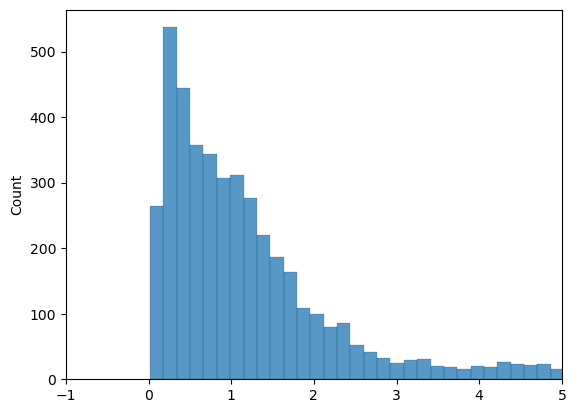

In [13]:
sns.histplot(sim.a)
plt.xlim([-1,5])

/home/smpuglie/vnc-closedloop/src/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


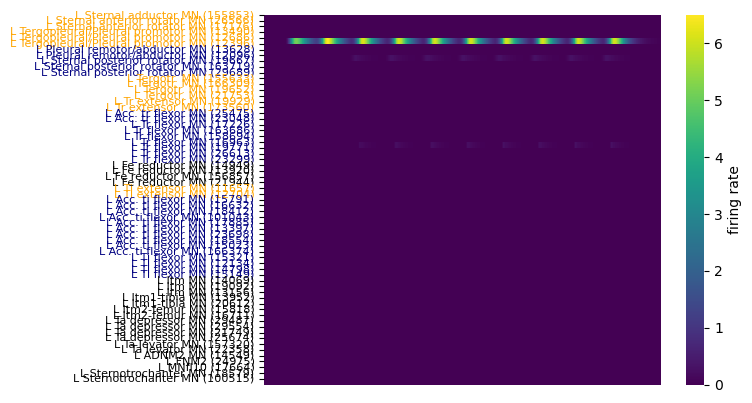

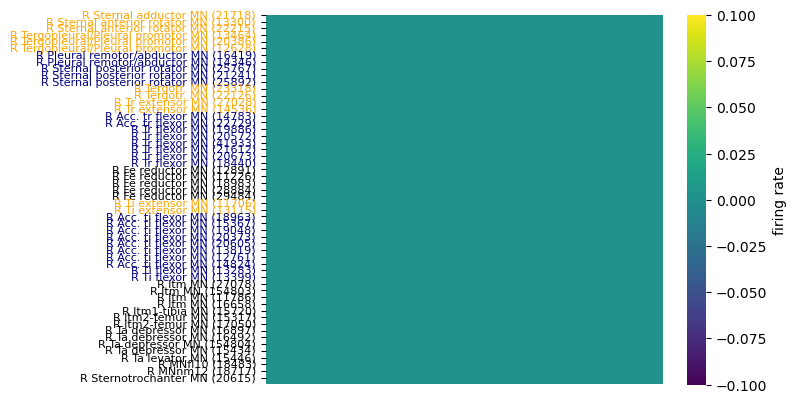

In [8]:
R = sim.R
allMNs = sort_motor_modules(wTable.loc[wTable["class"] == "motor neuron"])
lMNs = allMNs.loc[allMNs["somaSide"]=="LHS"].copy()
rMNs = allMNs.loc[allMNs["somaSide"]=="RHS"].copy()


ax = plot_R_heatmap(R,lMNs,activeOnly=False)#,space=spacer,figsize=(width,5))
plt.figure()
ax = plot_R_heatmap(R,rMNs,activeOnly=False)#,space=spacer,figsize=(width,5))


In [39]:
# np.save("../results/20250316_mancBDN2activation_seed2144_latestParams.npy",R)
# R = np.load("../results/20250316_mancBDN2activation_seed8580_latestParams.npy")

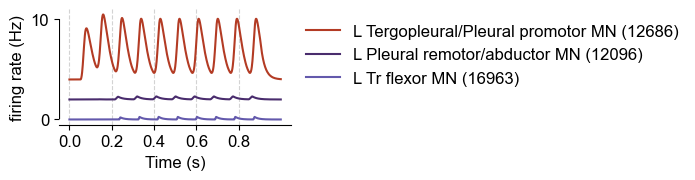

Could not generate RHS figure.


/home/smpuglie/vnc-closedloop/src/plot_utils.py:144: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper left",bbox_to_anchor=[1,1],edgecolor="None",facecolor="None")
/home/smpuglie/miniconda3/envs/vnc-closedloop/lib/python3.12/site-packages/matplotlib/_tight_bbox.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/home/smpuglie/miniconda3/envs/vnc-closedloop/lib/python3.12/site-packages/matplotlib/_tight_bbox.py:68: RuntimeWarning: divide by zero encountered in scalar divide
  fig.bbox.width / w1, fig.bbox.height / h1)
/home/smpuglie/miniconda3/envs/vnc-closedloop/lib/python3.12/site-packages/matplotlib/patches.py:797: RuntimeWarning: invalid value encountered in scalar add
  y1 = self.convert_yunits(self._y0 + self._height)
/home/smpuglie/miniconda3/envs/vnc-closedloop/lib/python3.12/site-

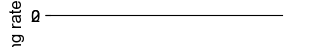

In [11]:
plt.rcParams["svg.fonttype"] = "none"

spacer=2
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["font.size"] = 12 #"Arial"
width = 3

try:
    plt.figure()
    ax = plot_R_traces_stacked_by_module(R,lMNs,activeOnly=True,space=spacer,figsize=(width,5))
    add_tAxis(ax,T,5)
    xlimits = ax.get_xlim()
    plt.vlines(xlimits[0],0,10,"k")
    plt.yticks([0,10])
    plt.xlim(xlimits)
    ax.spines[["left","top","right"]].set_visible(False)
    ax.grid(axis="x",color="lightgrey",linestyle="--")
    fig = plt.gcf()
    fig.set_figheight(0.5*len(get_active_data(R[lMNs.index],lMNs)))
    fig.set_figwidth(width)

    # fig.savefig("../results/figures/20250131_plots/manc_bdn2trace_lMNs_v3.svg",transparent=True)
    # fig.savefig("../results/figures/20250131_plots/manc_bdn2trace_lMNs_v3.png",bbox_inches="tight",transparent=True)

    # fig.savefig("../results/figures/20250304_plots/manc_dnb08idx0trace_lMNs.svg",transparent=True)
    # fig.savefig("../results/figures/20250304_plots/manc_dnb08idx0trace_lMNs.png",bbox_inches="tight",transparent=True,dpi=200)
    plt.show()
except:
    print("Could not generate LHS figure.")

try:
    plt.figure()
    ax = plot_R_traces_stacked_by_module(R,rMNs,activeOnly=True,space=spacer,figsize=(width,5))
    add_tAxis(ax,T,5)
    xlimits = ax.get_xlim()
    plt.vlines(xlimits[0],0,spacer,"k")
    plt.yticks([0,spacer])
    plt.xlim(xlimits)
    ax.spines[["left","top","right"]].set_visible(False)
    ax.grid(axis="x",color="lightgrey",linestyle="--")
    fig = plt.gcf()
    plt.gcf().set_figheight(0.5*len(get_active_data(R[rMNs.index],rMNs)))
    plt.gcf().set_figwidth(width)

    # fig.savefig("../results/figures/20250131_plots/manc_bdn2trace_rMNs_v3.svg",transparent=True)
    # fig.savefig("../results/figures/20250131_plots/manc_bdn2trace_rMNs_v3.png",bbox_inches="tight",transparent=True)

    # fig.savefig("../results/figures/20250131_plots/manc_dnb08trace_rMNs_v3_01.svg",transparent=True)
    # fig.savefig("../results/figures/20250131_plots/manc_dnb08trace_rMNs_v3_01.png",bbox_inches="tight",transparent=True)

    plt.show()
except:
    print("Could not generate RHS figure.")

/tmp/ipykernel_3497620/1578314121.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ax = plot_R_traces_stacked_2(R,pd.concat((wTable.loc[stimNeurons],lMNs)),activeOnly=True,space=2)


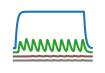

In [33]:
wTable.loc[bdn2s,"somaSide"] = ["LHS","RHS"]
plt.figure()
ax = plot_R_traces_stacked_2(R,pd.concat((wTable.loc[stimNeurons],lMNs)),activeOnly=True,space=2)
# add_tAxis(ax,T,5)
xlimits = ax.get_xlim()
# plt.vlines(xlimits[0],0,10,"k")
# plt.yticks([0,10])
ax.spines[:].set_visible(False)
ax.legend().set_visible(False)
plt.xlim(xlimits)
plt.yticks([])
plt.ylabel("")
# ax.spines[["left","top","right"]].set_visible(False)
# ax.grid(axis="x",color="lightgrey",linestyle="--")
fig = plt.gcf()
# fig.set_figheight(0.5*len(get_active_data(R[lMNs.index],lMNs)))
fig.set_figheight(0.698)
fig.set_figwidth(1.105)

# fig.savefig("../results/figures/20250131_plots/manc_bdn2trace_lMNs_v3.svg",transparent=True)
# fig.savefig("../results/figures/20250131_plots/manc_bdn2trace_lMNs_v3.png",bbox_inches="tight",transparent=True)

# fig.savefig("../results/figures/20250304_plots/manc_dnb08idx0trace_lMNs.svg",transparent=True)
# fig.savefig("../results/figures/20250304_plots/manc_dnb08idx0trace_lMNs.png",bbox_inches="tight",transparent=True,dpi=200)
plt.show()

In [20]:
pd.concat((wTable.loc[stimNeurons],lMNs))

/tmp/ipykernel_3497620/4728654.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pd.concat((wTable.loc[stimNeurons],lMNs))


,Unnamed: 0,bodyId,type,class,subclass,hemilineage,size,predictedNt,predictedNtProb,somaSide,motor module,step contribution
31,31,10093,DNxl058,descending neuron,xl,NaN,7124816452,acetylcholine,0.957519,NaN,NaN,NaN
4358,4358,155853,Sternal adductor MN,motor neuron,fl,TBD,1242893166,gaba,0.577582,LHS,coxa swing,swing
1073,1073,13490,Tergopleural/Pleural promotor MN,motor neuron,fl,TBD,1382555654,glutamate,0.596896,LHS,coxa swing,swing
860,860,12686,Tergopleural/Pleural promotor MN,motor neuron,fl,TBD,2832306624,glutamate,0.373590,LHS,coxa swing,swing
3224,3224,26566,Sternal anterior rotator MN,motor neuron,fl,TBD,2643221949,glutamate,0.440879,LHS,coxa swing,swing
...,...,...,...,...,...,...,...,...,...,...,...,...
1307,1307,14549,ADNM2 MN,motor neuron,nm,TBD,1406476915,glutamate,0.496159,LHS,NaN,NaN
1927,1927,17664,MNfl10,motor neuron,fl,TBD,1518766112,glutamate,0.578840,LHS,NaN,NaN
2086,2086,18579,Sternotrochanter MN,motor neuron,fl,17X.18X,2498444229,glutamate,0.463347,LHS,NaN,NaN
3029,3029,24975,FNM2,motor neuron,nm,16X,2034146125,glutamate,0.408434,LHS,NaN,NaN


In [41]:
score, freq = sim_oscillation_score(R[:,250:900],get_active_data(R[lMNs.index],lMNs).index,returnFrequency=True)
freq = freq/sim.dt

freq

14.563796533105995

In [30]:
seedOfSeedOfSeeds

2439

In [21]:
stimNeurons

[1208]

In [46]:
bodyIdToIdx(wTable,[13892,14061,14680,14966])

array([1162, 1208, 1334, 1400])

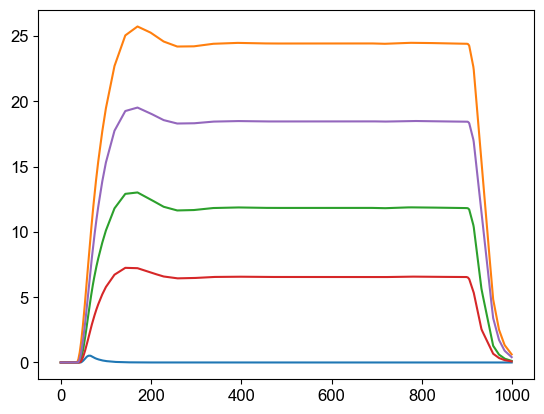

In [ ]:
# COXA DATA FOR ELLIOTT
activeCoMNs = get_active_data(R[allMNs.loc[allMNs["motor module"].isin(["coxa swing","coxa stance"])].index],allMNs)
activeCoMNlabels = neuron_plot_labels(activeCoMNs)
activeCoMNtraces = R[activeCoMNs.index]

activeCoMNdata = pd.DataFrame()
activeCoMNdata["t"] = sim.tAxis
for i in range(len(activeCoMNs)):
    activeCoMNdata[activeCoMNlabels[i]] = activeCoMNtraces[i]
    plt.plot(activeCoMNtraces[i])


# activeCoMNdata.to_csv(f"../results/{datetime.date.today().strftime(format='%Y%m%d')}_bdn2_CoMNexample_seed{seedOfSeedOfSeeds}_stimI{stimI}.csv")
# activeCoMNdata.to_csv(f"../results/{datetime.date.today().strftime(format='%Y%m%d')}_dna02r_CoMNexample_seed{seedOfSeedOfSeeds}_stimI{stimI}.csv")

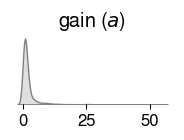

In [ ]:
plt.rcdefaults()
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["font.sans-serif"] = "FreeSans" #"Arial"
plt.rcParams["font.size"] = 12 #"Arial"

sns.displot(sim.a,color="#808080",kind="kde",height=2,fill=True) 
plt.title("gain ($a$)")
plt.yticks([])
plt.ylabel("")
plt.gca().spines[["left","bottom"]].set_visible(False)
plt.xticks([0,25,50])
plt.gcf().set_figheight(1)
plt.gcf().set_figwidth(3)

# plt.savefig("../results/figures/20250131_plots/param_dist_a_kde.png",bbox_inches="tight",transparent=True,dpi=200)
# plt.savefig("../results/figures/20250316_plots/param_dist_a_kde.svg",transparent=True)

In [ ]:
sns.displot(sim.a,color="#808080",height=2,fill=True) 
plt.title("gain ($a$)")
plt.xticks([0,5,10])
plt.xlim([-1,15])

# plt.savefig("../results/figures/20250131_plots/param_dist_a_hist_XLIMCUTOFF.png",bbox_inches="tight",transparent=True,dpi=200)

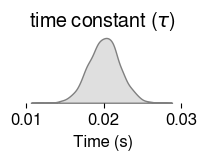

In [31]:
sns.displot(sim.tau,color="#808080",kind="kde",height=2,fill=True) 
plt.title("time constant ($τ$)")
plt.xticks([0.01,0.02,0.03])
plt.xlabel("Time (s)")
plt.yticks([])
plt.ylabel("")
plt.gca().spines[["left","bottom"]].set_visible(False)
plt.gcf().set_figheight(1)
plt.gcf().set_figwidth(3)

# plt.savefig("../results/figures/20250131_plots/param_dist_tau_kde.png",bbox_inches="tight",transparent=True,dpi=200)
# plt.savefig("../results/figures/20250316_plots/param_dist_tau_kde.svg",transparent=True)

In [ ]:
sns.displot(sim.tau,color="#808080",height=2,fill=True) 
plt.title("time constant ($τ$)")
plt.xticks([0.01,0.02,0.03])
plt.xlabel("Time (s)")

# plt.savefig("../results/figures/20250131_plots/param_dist_tau_hist.png",bbox_inches="tight",transparent=True,dpi=200)

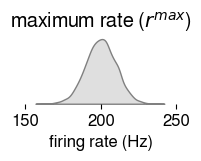

In [ ]:
sns.displot(sim.frCap,color="#808080",kind="kde",height=2,fill=True) 
plt.title(r"maximum rate ($r^{max}$)")
plt.xticks([150,200,250])
plt.xlabel("firing rate (Hz)")
plt.yticks([])
plt.ylabel("")
plt.gca().spines[["left","bottom"]].set_visible(False)
plt.gcf().set_figheight(1)
plt.gcf().set_figwidth(3)

# plt.savefig("../results/figures/20250131_plots/param_dist_rmax_kde.png",bbox_inches="tight",transparent=True,dpi=200)
# plt.savefig("../results/figures/20250316_plots/param_dist_rmax_kde.svg",transparent=True)

In [ ]:
sns.displot(sim.frCap,color="#808080",height=2,fill=True) 
plt.title(r"maximum rate ($r^{max}$)")
plt.xticks([150,200,250])
plt.xlabel("firing rate (Hz)")

# plt.savefig("../results/figures/20250131_plots/param_dist_rmax_hist.png",bbox_inches="tight",transparent=True,dpi=200)

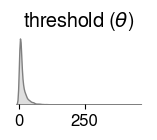

In [ ]:
sns.displot(sim.threshold,color="#808080",kind="kde",height=2,fill=True) 
plt.title("threshold ($θ$)")
# plt.xlabel("input")

plt.yticks([])
plt.ylabel("")
plt.gca().spines[["left","bottom"]].set_visible(False)
plt.gcf().set_figheight(1)
plt.gcf().set_figwidth(3)
# plt.savefig("../results/figures/20250131_plots/param_dist_theta_kde.png",bbox_inches="tight",transparent=True,dpi=200)
# plt.savefig("../results/figures/20250316_plots/param_dist_theta_kde.svg",transparent=True)

In [ ]:
sns.displot(sim.threshold,color="#808080",height=2,fill=True) 
plt.title("threshold ($θ$)")
plt.xlim([-10,100])
plt.xticks(np.arange(0,100,25))
plt.xlabel("input")

# plt.savefig("../results/figures/20250131_plots/param_dist_theta_hist_XLIMCUTOFF.png",bbox_inches="tight",transparent=True,dpi=200)

In [ ]:
np.max(sim.a)

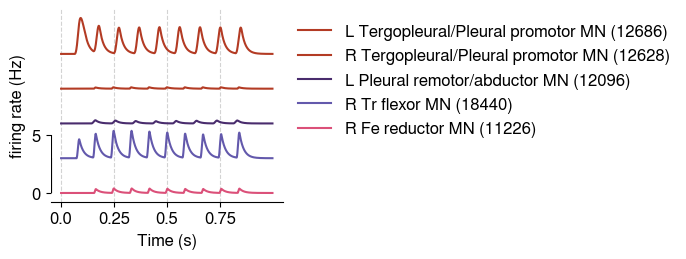

In [57]:
spacer=3
width = 3
plt.figure()
ax = plot_R_traces_stacked_by_module(R,allMNs,activeOnly=True,space=spacer,figsize=(width,5))
add_tAxis(ax,T,4)
xlimits = ax.get_xlim()
plt.vlines(xlimits[0],0,5,"k")
plt.yticks([0,5])
plt.xlim(xlimits)
ax.spines[["left","top","right"]].set_visible(False)
ax.grid(axis="x",color="lightgrey",linestyle="--")
fig = plt.gcf()
fig.set_figheight(0.5*len(get_active_data(R[allMNs.index],allMNs)))
fig.set_figwidth(width)

# fig.savefig("../results/figures/20250316_plots/manc_bdn2trace_allMNs_v2.svg",transparent=True)
# fig.savefig("../results/figures/20250131_plots/manc_bdn2trace_allMNs_v3.png",bbox_inches="tight",transparent=True)

In [ ]:
spacer=3
width = 3
fig, axes = plt.subplots(2,1,sharex=True, sharey=False,
                         height_ratios=[len(get_active_data(R[lMNs.index],lMNs)),
                                        len(get_active_data(R[rMNs.index],rMNs))])
ax = axes[0]
plot_R_traces_stacked_by_module(R,lMNs,activeOnly=True,space=spacer,ax=ax)
add_tAxis(ax,T,4)
axes[0].set_xlabel("")
ax.spines[["left","top","right"]].set_visible(False)
ax.grid(axis="x",color="lightgrey",linestyle="--")

ax = axes[1]
plot_R_traces_stacked_by_module(R,rMNs,activeOnly=True,space=spacer,ax=ax)
add_tAxis(ax,T,4)
xlimits = ax.get_xlim()
plt.vlines(xlimits[0],0,5,"k")
plt.yticks([0,5])
plt.xlim(xlimits)
ax.spines[["left","top","right"]].set_visible(False)
ax.grid(axis="x",color="lightgrey",linestyle="--")
fig.set_figheight(0.5*len(get_active_data(R[allMNs.index],allMNs)))
fig.set_figwidth(width)

# fig.savefig("../results/figures/20250316_plots/manc_bdn2trace_allMNs.svg",transparent=True)
# fig.savefig("../results/figures/20250131_plots/manc_bdn2trace_allMNs_v3.png",bbox_inches="tight",transparent=True)

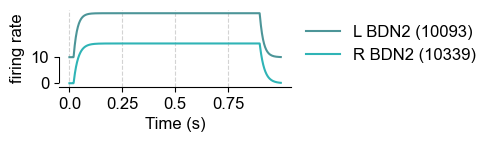

In [ ]:
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["font.sans-serif"] = "Arial"

spacer = 10

bdn2Data = wTable.loc[bdn2s].copy()
bdn2Data["somaSide"] = ["L","R"]
bdn2Data["type"] = ["BDN2","BDN2"]

# dnb08Data = wTable.loc[wTable["type"]=="DNxl027"].copy()
# dnb08Data["somaSide"] = ["L","L","R","R"]
# dnb08Data["type"] = ["DNb08"]*4

plt.figure()
ax = plot_R_traces_stacked_2(R,bdn2Data,activeOnly=False,space=spacer,colors=["#4c9598","#2fb4b6"])
add_tAxis(ax,T,4)
xlimits = ax.get_xlim()
plt.vlines(xlimits[0],0,10,"k")
plt.yticks([0,10])
plt.xlim(xlimits)
ax.spines[["left","top","right"]].set_visible(False)
ax.grid(axis="x",color="lightgrey",linestyle="--")
fig = plt.gcf()
fig.set_figheight(1)
fig.set_figwidth(width)

# fig.savefig("../results/figures/20250316_plots/manc_bdn2trace_bdn2_seed8580.svg",transparent=True)
# fig.savefig("../results/figures/20250131_plots/manc_bdn2trace_bdn2_v2.png",bbox_inches="tight",transparent=True)

# fig.savefig("../results/figures/20250304_plots/manc_dnb08idx0trace_dnb08s.svg",transparent=True)
# fig.savefig("../results/figures/20250304_plots/manc_dnb08idx0trace_dnb08s.png",bbox_inches="tight",transparent=True)

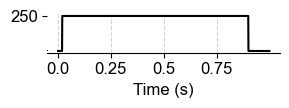

In [ ]:
plt.figure()

plt.plot(sim.inputs[bdn2s[0]],"k")
ax = plt.gca()
add_tAxis(ax,T,4)
xlimits = ax.get_xlim()
plt.vlines(xlimits[0],0,10,"k")
plt.yticks([250])
plt.xlim(xlimits)
ax.spines[["left","top","right"]].set_visible(False)
ax.grid(axis="x",color="lightgrey",linestyle="--")
fig = plt.gcf()
fig.set_figheight(0.5)
fig.set_figwidth(width)

# fig.savefig("../results/figures/20250316_plots/manc_bdn2trace_input.svg",transparent=True)

In [ ]:
inxxx464s = bodyIdToIdx(wTable,[10274, 162543]) # L, L, R, R

# colors = ["#00755E","#BEE64B","#803790","#CA3435"]
# lhsColorMap = sns.blend_palette(["#00755E","#BEE64B","#F2C649"],as_cmap=True)
# rhsColorMap = sns.blend_palette(["#803790","#CA3435","#FEBAAD"],as_cmap=True)
spacer = 5
plt.figure()
plot_R_traces(R,wTable.loc[np.hstack((inxxx464s,inxxx466s))],activeOnly=False,cmap="tab10",figsize=(5,5))
add_tAxis(plt.gca(),T,5)
plt.yticks([0,spacer])
# plt.gcf().set_figheight(0.5*len(get_active_data(R[rMNs.index],rMNs)))
# plt.gcf().set_figheight(0.2*len(rMNs))

plt.show()

In [ ]:
wTable.loc[inxxx468s]

In [ ]:

plt.plot(R[3652])
plt.plot(R[4091])
plt.plot(R[4301])
plt.plot(R[4302])

plt.plot(sim.inputs[4301])


In [ ]:
plt.figure(figsize=(6,2))
plt.plot(sim.inputs[proprioceptorIdxs,:].T,"k")
plt.gca().spines[["top","right"]].set_visible(False)
add_tAxis(plt.gca(),T,5)
# plt.title("Input to R claw neurons")

In [ ]:
# plt.rcdefaults()


R = sim.R
allMNs = sort_motor_modules(wTable.loc[wTable["class"] == "motor neuron"])
lMNs = allMNs.loc[allMNs["somaSide"]=="LHS"].copy()
rMNs = allMNs.loc[allMNs["somaSide"]=="RHS"].copy()

spacer=20
plt.rcParams["font.sans-serif"] = "FreeSans" #"Arial"
# fig, axes = plt.subplots(2,1)
# lhsAx = axes[0]
# rhsAx = axes[1]

fig,ax = plt.subplots(4,1,sharex=True,height_ratios=[1,1,0.5*len(get_active_data(R[lMNs.index],lMNs)),0.5*len(get_active_data(R[rMNs.index],rMNs))])

ax[0].plot(sim.inputs[proprioceptorIdxs[0]].T,"k")
ax[0].spines[["top","right"]].set_visible(False)
add_tAxis(ax[0],T,5)
ax[0].set_ylabel("I(t)")
# plt.title("Input to R claw neurons")

ax[1].plot(R[proprioceptorIdxs,:].T,"k")
ax[1].spines[["top","right"]].set_visible(False)
add_tAxis(ax[0],T,5)
ax[1].set_ylabel("firing rate")

plot_R_traces_stacked_2(R,lMNs,activeOnly=True,cmap=lhsColorMap,space=spacer,figsize=(5,5),ax=ax[2])
ax[2].set_yticks([0,spacer])
add_tAxis(ax[1],T,5)
ax[2].set_ylabel("firing rate")
ax[2].set_facecolor("None")
ax[2].spines[["top","right"]].set_visible(False)
ax[2].legend(loc="upper left",bbox_to_anchor=[1,1],edgecolor="None",facecolor="None")
# plt.gcf().set_figheight(0.5*len(get_active_data(R[lMNs.index],lMNs)))
# plt.gcf().set_figheight(0.2*len(lMNs))

plot_R_traces_stacked_2(R,rMNs,activeOnly=True,cmap=rhsColorMap,space=spacer,figsize=(5,5),ax=ax[3])
add_tAxis(ax[3],T,5)
ax[3].set_yticks([0,spacer])
# plt.gcf().set_figheight(0.5*len(get_active_data(R[rMNs.index],rMNs)))
# plt.gcf().set_figheight(0.2*len(rMNs))

fig.set_figheight(10)

# ax = plot_R_traces_stacked_2(R,allMNs,activeOnly=True,cmap="turbo",space=spacer,figsize=(2,2))
# add_tAxis(ax,T,5)
plt.subplots_adjust(hspace=0.2)

In [ ]:
# # plt.plot(R[bodyIdToIdx(wTable,[13628])[0]],label="L pleural remotor",c="darkgreen")
# plt.plot(R[bodyIdToIdx(wTable,[12096])[0]],label="L pleural remotor",c="darkgreen")
# # plt.plot(R[bodyIdToIdx(wTable,[16419])[0]],label="R pleural remotor",c="purple")
# # plt.plot(R[bodyIdToIdx(wTable,[14346])[0]],label="R pleural remotor",c="purple")


plt.plot(R[bodyIdToIdx(wTable,[12686])[0]],label="L pleural promotor",c="lightgreen")
plt.plot(R[bodyIdToIdx(wTable,[12628])[0]],label="R pleural promotor",c="purple")

# plt.plot(R[bodyIdToIdx(wTable,[101043])[0]],label="L acc ti flexor remotor",c="darkgreen")
# plt.plot(R[bodyIdToIdx(wTable,[12761])[0]],label="R acc ti flexor remotor",c="purple")
plt.legend()

In [ ]:
plt.rcdefaults()

allMNs = sort_motor_modules(wTable.loc[wTable["class"] == "motor neuron"])
lMNs = allMNs.loc[allMNs["somaSide"]=="LHS"].copy()
rMNs = allMNs.loc[allMNs["somaSide"]=="RHS"].copy()

avgR = sim.R

lMNidxs = lMNs.index

# lMNs = wTable[wTable["annotation_table"].str.contains("motor_neuron")].copy()
# lMNs["motor module"] = pd.Categorical(lMNs["motor module"],["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",
#                                                                 "femur reductor", "tibia extend", "tibia flex A", "tibia flex B",
#                                                                 "tibia flex C", "substrate grip", "tarsus control"])
# lMNs.sort_values("type",inplace=True)
# lMNs.sort_values("motor module",inplace=True)

# lMNs.index = lMNs["w_idx"].to_numpy()
# nMNs = len(lMNs.index)

plt.rcParams['font.sans-serif'] = "FreeSans" #Arial
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(3,1,sharex=True,layout="constrained",height_ratios=[1,1,10]) #,figsize=(6,10))
# fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(13)

ax[0].plot(sim.inputs[stimNeurons[0],:],"k",label="BDN2 L")
# ax[0].plot(sim.inputs[stimNeurons[1],:],"gray",label="IN17A001 R")
ax[0].set_ylabel("Input",rotation=0,fontsize=18,horizontalalignment="right")
ax[0].legend(handlelength=0,loc="upper left",bbox_to_anchor=[1,1],
           edgecolor="none",labelcolor="markeredgecolor")
ax[0].spines[:].set_visible(False)
# ax[0].set_xticks(np.linspace())

ax[1].plot(avgR[stimNeurons[0],:],"k",label="BDN2 L")
# ax[1].plot(avgR[stimNeurons[1],:],"gray",label="IN17A001 R")
ax[1].set_ylabel("Firing rate",rotation=0,fontsize=18,horizontalalignment="right")
ax[1].legend(handlelength=0,loc="upper left",bbox_to_anchor=[1,1],
           edgecolor="none",labelcolor="markeredgecolor")
ax[1].spines[:].set_visible(False)
# ax[0].set_xticks(np.linspace())

ax[2].xaxis.tick_bottom()
ax[2].set_xlim((0,np.size(avgR,1)))
ticklocs = ax[2].xaxis.get_ticklocs()
ax[2].set_xticks(ticklocs,labels=ticklocs*sim.dt,rotation=30)
ax[2].set_yticks(np.arange(0,len(lMNs.index)),labels=[s.replace("_"," ") for s in lMNs["type"]],fontsize=10)

stanceIdxs = np.where(lMNs["step contribution"]=="stance")[0]
swingIdxs = np.where(lMNs["step contribution"]=="swing")[0]
[ax[2].get_yticklabels()[i].set_color("navy") for i in stanceIdxs]
[ax[2].get_yticklabels()[i].set_color("orange") for i in swingIdxs]
ax[2].set_ylabel("T1L motor neurons",fontsize=18)
# ax[2].set_title("FANC IN17A001 activation",fontsize=20)

plt.imshow(avgR[lMNs.index,:],aspect="auto",interpolation="none")#,vmin=0)#,vmax=10) #,vmin=0,vmax=200)
c = plt.colorbar(ax=ax[2],label="firing rate (Hz)",shrink=0.6)
plt.xlabel("Time (ms)")
# plt.show()

# saveFigs = True
if saveFigs:
    dateStr = datetime.date.today().strftime(format="%Y%m%d")
    # figStr = f"fancBDN2andClawWithMnInput20Hz_avg{nSims}sims_seedOfSeedOfSeeds{seedOfSeedOfSeeds}_stimI{stimI}"
    figStr = f"fancBDN2andClawWithoutMnInput_avg{nSims}sims_seedOfSeedOfSeeds{seedOfSeedOfSeeds}_stimI{stimI}"
    saveStr = dateStr+"_"+figStr
    saveDir = "../results/figures/"+saveStr+"/"
    if not os.path.exists(saveDir):
        os.makedirs(saveDir)

    plt.savefig(saveDir+saveStr+".svg")
    plt.savefig(saveDir+saveStr+".png",bbox_inches = "tight")

fig.set_figwidth(8)

# fig,ax = plot_R_heatmap(sim.R,lMNs)
# add_tAxis(ax,sim.T,5)

In [ ]:
plt.rcdefaults()
allMNs = sort_motor_modules(wTable.loc[wTable["class"] == "motor neuron"])
rMNs = allMNs.loc[allMNs["somaSide"]=="LHS"].copy()
rMNs = allMNs.loc[allMNs["somaSide"]=="RHS"].copy()

avgR = sim.R

lMNidxs = rMNs.index
rMNidxs = rMNs.index

# rMNs = wTable[wTable["annotation_table"].str.contains("motor_neuron")].copy()
# rMNs["motor module"] = pd.Categorical(rMNs["motor module"],["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",
#                                                                 "femur reductor", "tibia extend", "tibia flex A", "tibia flex B",
#                                                                 "tibia flex C", "substrate grip", "tarsus control"])
# rMNs.sort_values("type",inplace=True)
# rMNs.sort_values("motor module",inplace=True)

# rMNs.index = rMNs["w_idx"].to_numpy()
# nMNs = len(rMNs.index)

plt.rcParams['font.sans-serif'] = "FreeSans"
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(3,1,sharex=True,layout="constrained",height_ratios=[1,1,10]) #,figsize=(6,10))
# fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(13)

# ax[0].plot(sim.inputs[stimNeurons[0],:],"k",label="IN17A001 L")
ax[0].plot(sim.inputs[stimNeurons[1],:],"gray",label="IN17A001 R")
ax[0].set_ylabel("Input",rotation=0,fontsize=18,horizontalalignment="right")
ax[0].legend(handlelength=0,loc="upper left",bbox_to_anchor=[1,1],
           edgecolor="none",labelcolor="markeredgecolor")
ax[0].spines[:].set_visible(False)
# ax[0].set_xticks(np.linspace())

# ax[1].plot(avgR[stimNeurons[0],:],"k",label="IN17A001 L")
ax[1].plot(avgR[stimNeurons[1],:],"gray",label="IN17A001 R")
ax[1].set_ylabel("Firing rate",rotation=0,fontsize=18,horizontalalignment="right")
ax[1].legend(handlelength=0,loc="upper left",bbox_to_anchor=[1,1],
           edgecolor="none",labelcolor="markeredgecolor")
ax[1].spines[:].set_visible(False)
# ax[0].set_xticks(np.linspace())

ax[2].xaxis.tick_bottom()
ax[2].set_xlim((0,np.size(avgR,1)))
ticklocs = ax[2].xaxis.get_ticklocs()
ax[2].set_xticks(ticklocs,labels=ticklocs*sim.dt,rotation=30)
ax[2].set_yticks(np.arange(0,len(rMNs.index)),labels=[s.replace("_"," ") for s in rMNs["type"]],fontsize=10)

stanceIdxs = np.where(rMNs["step contribution"]=="stance")[0]
swingIdxs = np.where(rMNs["step contribution"]=="swing")[0]
[ax[2].get_yticklabels()[i].set_color("navy") for i in stanceIdxs]
[ax[2].get_yticklabels()[i].set_color("orange") for i in swingIdxs]
ax[2].set_ylabel("T1R motor neurons",fontsize=18)
# ax[2].set_title("FANC IN17A001 activation",fontsize=20)

plt.imshow(avgR[rMNs.index,:],aspect="auto",interpolation="none",vmin=0,vmax=10) #,vmin=0,vmax=200)
c = plt.colorbar(ax=ax[2],label="firing rate (Hz)",shrink=0.6)
plt.xlabel("Time (ms)")
# plt.show()

# saveFigs = True
if saveFigs:
    dateStr = datetime.date.today().strftime(format="%Y%m%d")
    # figStr = f"fancBDN2andClawWithMnInput20Hz_avg{nSims}sims_seedOfSeedOfSeeds{seedOfSeedOfSeeds}_stimI{stimI}"
    figStr = f"fancBDN2andClawWithoutMnInput_avg{nSims}sims_seedOfSeedOfSeeds{seedOfSeedOfSeeds}_stimI{stimI}"
    saveStr = dateStr+"_"+figStr
    saveDir = "../results/figures/"+saveStr+"/"
    if not os.path.exists(saveDir):
        os.makedirs(saveDir)

    plt.savefig(saveDir+saveStr+".svg")
    plt.savefig(saveDir+saveStr+".png",bbox_inches = "tight")

fig.set_figwidth(8)

# fig,ax = plot_R_heatmap(sim.R,rMNs)
# add_tAxis(ax,sim.T,5)

In [ ]:
sns.set(font_scale=1)
plt.rcParams["svg.fonttype"] = "none"

fig = plt.figure(layout="constrained")
fig.suptitle("All active motor neurons")

subfigs = fig.subfigures(2,1,hspace=-0.2)
lhsColorMap = sns.blend_palette(["#00755E","#BEE64B","#F2C649"],as_cmap=True)
rhsColorMap = sns.blend_palette(["#803790","#CA3435","#FEBAAD"],as_cmap=True)

lhsFig,lhsAxes= plot_R_traces_stacked(avgR,lMNs,activeOnly=True,cmap=lhsColorMap,hspace=-0.8,figsize=(2,2),fig=subfigs[0],ymax=10)
add_tAxis(lhsAxes[-1],T,5)
for ax in lhsAxes:
    ax.grid(axis="x",color="k")
plt.tick_params("y",tick1On=True)
plt.tick_params("y",gridOn=False)
lhsAxes[-1].set_xticklabels([])
lhsAxes[-1].set_xlabel("")

# plt.suptitle(f'Interneurons')
# plt.gcf().set_figheight(5)
rhsFig,rhsAxes= plot_R_traces_stacked(avgR,rMNs,activeOnly=True,cmap=rhsColorMap,hspace=-0.8,figsize=(2,2),fig=subfigs[1],ymax=10)
add_tAxis(rhsAxes[-1],T,5)
for ax in rhsAxes:
    ax.grid(axis="x",color="k")
plt.tick_params("both",tick1On=True)
plt.tick_params("y",gridOn=False)
# rhsFig.set_figheight(10)
# plt.show()

# fig.savefig("../results/figures/20240926_amputationPlots_bdn2trace.svg")
# fig.savefig("../results/figures/20240926_amputationPlots_bdn2trace.png")

In [ ]:
spacer=30
plt.rcdefaults()
# fig, axes = plt.subplots(2,1)
# lhsAx = axes[0]
# rhsAx = axes[1]
plt.figure()
plot_R_traces_stacked_2(avgR,lMNs,activeOnly=True,cmap=lhsColorMap,space=spacer,figsize=(2,2))
plt.yticks([0,spacer])
add_tAxis(plt.gca(),T,5)
plt.gcf().set_figheight(0.5*len(get_active_data(avgR[lMNs.index],lMNs)))

plt.figure()
plot_R_traces_stacked_2(avgR,rMNs,activeOnly=True,cmap=rhsColorMap,space=spacer,figsize=(2,2))
add_tAxis(plt.gca(),T,5)
plt.yticks([0,spacer])
plt.gcf().set_figheight(0.5*len(get_active_data(avgR[rMNs.index],rMNs)))

# ax = plot_R_traces_stacked_2(avgR,allMNs,activeOnly=True,cmap="turbo",space=spacer,figsize=(2,2))
# add_tAxis(ax,T,5)


In [ ]:
plt.imshow(sim.R,aspect="auto")
plt.colorbar()

In [ ]:
np.max(sim.R)

np.argmax(sim.R,axis=0)

In [ ]:
np.max(sim.R)

In [ ]:
np.max(sim.R,axis=1)

In [ ]:
wTable.loc[np.unique(np.argmax(sim.R,axis=0))]

In [ ]:
for i in np.unique(np.argmax(sim.R,axis=0))[1:]:
    plt.plot(avgR[i],label=wTable.loc[i,"type"])

plt.legend(loc="right")

In [ ]:
for i in wTable.loc[wTable["type"]=="IN16B009"].index:
    plt.plot(avgR[i],label=wTable.loc[i,"somaSide"])

plt.legend(loc="right")

In [ ]:
for i in wTable.loc[wTable["hemilineage"]=="16B"].index:
    plt.plot(avgR[i],label=wTable.loc[i,"somaSide"])

# plt.legend(loc="right")

In [ ]:
for i in wTable.loc[wTable["hemilineage"]=="19A"].index:
    plt.plot(avgR[i],label=wTable.loc[i,"somaSide"])

In [ ]:
np.argmax(np.array([[4,2,3],[1,0,3]]),axis=1)

In [ ]:
sns.set(font_scale=1)

lhsColorMap = sns.blend_palette(["#00755E","#BEE64B","#F2C649"],as_cmap=True)
rhsColorMap = sns.blend_palette(["#803790","#CA3435","#FEBAAD"],as_cmap=True)

fig,axes= plot_R_traces_stacked(avgR,rMNs,activeOnly=True,cmap=rhsColorMap,hspace=-0.6,figsize=(3,3))
add_tAxis(axes[-1],T,5)
for ax in axes:
    ax.grid(axis="x",color="k")
plt.tick_params("both",tick1On=True)
plt.tick_params("y",gridOn=False)
# plt.suptitle(f'Interneurons')
# plt.gcf().set_figheight(5)

In [ ]:
plt.rcParams['font.sans-serif'] = "FreeSans"
plt.rcParams['font.size'] = 16

lhsColorMap = sns.blend_palette(["#00755E","#BEE64B","#F2C649"],as_cmap=True)
rhsColorMap = sns.blend_palette(["#803790","#CA3435","#FEBAAD"],as_cmap=True)

ax = plot_R_traces(avgR,lMNs,cmap=lhsColorMap,activeOnly=True)
ax2 = plot_R_traces(avgR,rMNs,cmap=rhsColorMap,activeOnly=True)
add_tAxis(ax,T,5)
ax.spines[:].set_color("k")
ax.tick_params(color="k",tick1On=True)
# ax.legend.set_facecolor("None")
# plt.suptitle(f'Interneurons')
# plt.gcf().set_figheight(5)

In [ ]:
sns.set(font_scale=1)

plt.rcParams['font.sans-serif'] = "Arial" #"FreeSans" linux, "Arial" Mac
plt.rcParams['font.size'] = 16
plt.rcParams["svg.fonttype"] = "none"


bdn2Data = wTable.loc[bdn2s].copy()
bdn2Data["somaSide"] = ["L","R"]
bdn2Data["type"] = ["BDN2","BDN2"]

spacer = 3

lhsColorMap = sns.blend_palette(["#00755E","#BEE64B","#F2C649"],as_cmap=True)
rhsColorMap = sns.blend_palette(["#803790","#CA3435","#FEBAAD"],as_cmap=True)

# plot_R_traces_stacked_2(avgR,bdn2Data,colors=["black","gray"],activeOnly=True,space=spacer,start=spacer*11)
plot_R_traces_stacked_2(avgR,lMNs,cmap=lhsColorMap,activeOnly=True,space=spacer,start=spacer*8)
plot_R_traces_stacked_2(avgR,rMNs,cmap=rhsColorMap,activeOnly=True,space=spacer)

ax = plt.gca()
add_tAxis(ax,T,5)

ax.tick_params(color="k",tick1On=True)
ax.grid(axis="x",color="grey")
ax.spines[:].set_visible(False)
plt.tick_params("both",tick1On=True)
plt.tick_params("y",gridOn=False)
ax.set_yticks([0,5])

fig = plt.gcf()
fig.set_figheight(2.5)
fig.set_figwidth(2)
plt.title("All active motor neurons")
# add_tAxis(ax,T,5)
# ax.spines[:].set_color("k")
# ax.tick_params(color="k",tick1On=True)
# # ax.legend.set_facecolor("None")
# # plt.suptitle(f'Interneurons')
# # plt.gcf().set_figheight(5)

# ax2.get_legend_handles_labels()

# fig.savefig("../results/figures/202401001_plots/bdn2trace_13698silenced_stimI225_v2.svg")
# fig.savefig("../results/figures/202401001_plots/bdn2trace_13698silenced_stimI225_v2.png",bbox_inches="tight")

In [ ]:
sns.set(font_scale=1)

plt.rcParams['font.sans-serif'] = "Arial" #"FreeSans" linux, "Arial" Mac
plt.rcParams['font.size'] = 16
plt.rcParams["svg.fonttype"] = "none"


bdn2Data = wTable.loc[bdn2s].copy()
bdn2Data["somaSide"] = ["L","R"]
bdn2Data["type"] = ["BDN2","BDN2"]

spacer = 

lhsColorMap = sns.blend_palette(["#00755E","#BEE64B","#F2C649"],as_cmap=True)
rhsColorMap = sns.blend_palette(["#803790","#CA3435","#FEBAAD"],as_cmap=True)

plot_R_traces_stacked_2(avgR,wTable.loc[inxxx466s],colors=["k","darkgray"],activeOnly=True,space=0,start=0)
ax = plt.gca()
add_tAxis(ax,T,5)

ax.tick_params(color="k",tick1On=True)
ax.grid(axis="x",color="grey")
ax.spines[:].set_visible(False)
plt.tick_params("both",tick1On=True)
plt.tick_params("y",gridOn=False)
ax.set_yticks([0,5])

fig = plt.gcf()
fig.set_figheight(1.2)
fig.set_figwidth(2)
# fig.savefig("../results/figures/20241008_plots/bdn2trace_bdn2s_v4.svg")
# fig.savefig("../results/figures/20241008_plots/bdn2trace_bdn2s_v4.png",bbox_inches="tight")


plt.figure()
# plot_R_traces_stacked_2(avgR,bdn2Data,colors=["black","gray"],activeOnly=True,space=spacer,start=spacer*11)
plot_R_traces_stacked_2(avgR,lMNs,cmap=lhsColorMap,activeOnly=True,space=spacer,start=spacer*len(get_active_data(avgR[rMNs.index],rMNs)))
plot_R_traces_stacked_2(avgR,rMNs,cmap=rhsColorMap,activeOnly=True,space=spacer)

ax = plt.gca()
add_tAxis(ax,T,5)

ax.tick_params(color="k",tick1On=True)
ax.grid(axis="x",color="grey")
ax.spines[:].set_visible(False)
plt.tick_params("both",tick1On=True)
plt.tick_params("y",gridOn=False)
ax.set_yticks([0,5])

fig = plt.gcf()
fig.set_figheight(2.5)
fig.set_figwidth(2)
plt.title("All active motor neurons")
# add_tAxis(ax,T,5)
# ax.spines[:].set_color("k")
# ax.tick_params(color="k",tick1On=True)
# # ax.legend.set_facecolor("None")
# # plt.suptitle(f'Interneurons')
# # plt.gcf().set_figheight(5)

# ax2.get_legend_handles_labels()

# fig.savefig("../results/figures/20241008_plots/bdn2trace_mns_v4.svg")
# fig.savefig("../results/figures/20241008_plots/bdn2trace_mns_v4.png",bbox_inches="tight")

## with proprioceptor inputs

In [ ]:
stimNeurons = bodyIdToIdx(wTable,[11070]) #11070 10656

# stimNeurons = [4301,4302]

# stimNeurons = bdn2s #bodyIdToIdx(wTable,[15650, 18076]) #dna02s # list of neurons to activate
# stimNeurons = wTable[wTable["bodyId"].isin([10274, 11751, 13698, 162543, 11110, 11374, 12021, 100139, 12068, 12901])].index.to_numpy().astype(int)
stimI = 150 #236.9914310058594 # Stimulus
# stimIs = np.arange(160,310,10)

# neuronsToRemove = bodyIdToIdx(wTable,[13698])  
# neuronsToRemove = wTable[wTable["type"]=="IN15A001"].index.to_numpy().astype(int) #bodyIdToIdx(wTable,[10690]) 
T = 1
dt = 0.005

nSims = 1 #3
sims = []

freq = 10

seedOfSeedOfSeeds = np.random.randint(10000) #8580
seedsOfSeeds = np.random.default_rng(seedOfSeedOfSeeds).integers(10000,size=nSims)

proprioceptorIdxs = [3652, 4091,4301,4302]

# cellVolumes = wTable["size"].to_numpy().astype(float)/512 # 512 nm3 per voxel ... maybe (methods are a little unclear)
# cellSurfareasApprox = pd.Series(cellVolumes**(2/3)) # these are not the surface areas to be c

for i in range(nSims):
# for stimI in stimIs:
    # seedOfSeeds = np.random.randint(10000)

    seeds = np.random.default_rng(seedsOfSeeds[i]).integers(10000,size=4)

    # seeds = np.random.default_rng(seedOfSeeds).integers(10000,size=4)


    sim = vncNet.Simulation(W)
    sim.set_time(T,dt)
    # sim.silence_neurons(neuronsToRemove)

    # Set input
    # sim.set_input(np.maximum(signal.square(np.sin(sim.tAxis*2*np.pi*freq)),0)*sim.pulse_input(0,T,stimI,stimNeurons))

    sim.set_input(sim.pulse_input(0.02,T-0.1,stimI,stimNeurons)
                  + (1-(np.maximum(signal.square(np.sin(sim.tAxis*2*np.pi*freq)),0)))*sim.pulse_input(0,T-0.1,20,proprioceptorIdxs))

    # Set parameters
    sim.set_tau_distribution(0.02,0.002,seed=seeds[0])
    sim.set_a_distribution(1,0.1,seed=seeds[1])
    sim.set_threshold_distribution(6,0.6,seed=seeds[2])
    sim.set_synapse_multipliers(0.03,0.03)
    sim.set_fr_distribution(200,10,seed=seeds[3])
    sim.set_sizes(wTable["size"])

    # sim.set_tau_distribution(0.02,0.0000001,seed=seeds[0])
    # sim.set_a_distribution(1,0.0000001,seed=seeds[1])
    # sim.set_threshold_distribution(6,0.0000001,seed=seeds[2])
    # sim.set_synapse_multipliers(0.03,0.03)
    # sim.set_fr_distribution(200,0.0000001,seed=seeds[3])
    # sim.set_sizes(wTable["size"])

    # sim.silence_neurons((wTable[wTable["bodyId"].isin([12068, 12901, 11110, 11374, 12021, 100139])].index.to_numpy()))

    sim.run()

    sims.append(sim)

    # print(f"Sim {i}")
    print(stimI)


# avgR = average_R(sims)

# Ramping up inputs to assess frequency vs input

In [ ]:
stimNeurons = bdn2s #bodyIdToIdx(wTable,[15650, 18076]) #dna02s # list of neurons to activate
# stimNeurons = wTable[wTable["bodyId"].isin([10274, 11751, 13698, 162543, 11110, 11374, 12021, 100139, 12068, 12901])].index.to_numpy().astype(int)
# stimI = 180 # Stimulus
stimIs = np.arange(160,310,10)

# neuronsToRemove = bodyIdToIdx(wTable,[13698,10274]) #wTable[wTable["bodyId"]==10707].index.to_numpy().astype(int)
T = 1
dt = 0.0001

nSims = 1 #3
sims = []

# seedOfSeedOfSeeds = np.random.randint(10000)
# seedsOfSeeds = np.random.default_rng(seedOfSeedOfSeeds).integers(10000,size=nSims)

# cellVolumes = wTable["size"].to_numpy().astype(float)/512 # 512 nm3 per voxel ... maybe (methods are a little unclear)
# cellSurfareasApprox = pd.Series(cellVolumes**(2/3)) # these are not the surface areas to be c

# for i in range(nSims):
for stimI in stimIs:
    seedOfSeeds = np.random.randint(10000)

    # seeds = np.random.default_rng(seedsOfSeeds[i]).integers(10000,size=4)

    seeds = np.random.default_rng(seedOfSeeds).integers(10000,size=4)


    sim = vncNet.Simulation(W)
    sim.set_time(T,dt)
    # sim.silence_neurons(neuronsToRemove)

    # Set input

    sim.set_input(sim.pulse_input(0.02,0.9,stimI,stimNeurons))

    # # Set parameters
    # sim.set_tau_distribution(0.02,0.004,seed=seeds[0])
    # sim.set_a_distribution(1,0.2,seed=seeds[1])
    # sim.set_threshold_distribution(6,2,seed=seeds[2])
    # sim.set_synapse_multipliers(0.03,0.03)
    # sim.set_fr_distribution(200,10,seed=seeds[3])
    # sim.set_sizes(wTable["size"])

    sim.set_tau_distribution(0.02,0.0000001,seed=seeds[0])
    sim.set_a_distribution(1,0.0000001,seed=seeds[1])
    sim.set_threshold_distribution(6,0.0000001,seed=seeds[2])
    sim.set_synapse_multipliers(0.03,0.03)
    sim.set_fr_distribution(200,0.0000001,seed=seeds[3])
    sim.set_sizes(wTable["size"])

    # sim.silence_neurons((wTable[wTable["bodyId"].isin([12068, 12901, 11110, 11374, 12021, 100139])].index.to_numpy()))

    sim.run()

    sims.append(sim)

    # print(f"Sim {i}")
    print(stimI)


# avgR = average_R(sims)

In [ ]:
lhsColorMap = sns.blend_palette(["#00755E","#BEE64B","#F2C649"],as_cmap=True)
rhsColorMap = sns.blend_palette(["#803790","#CA3435","#FEBAAD"],as_cmap=True)

for i in range(len(sims)):
    R = sims[i].R
    fig,ax = plot_R_traces(R,wTable.loc[(wTable["class"] == "motor neuron")&(wTable["somaSide"] == "LHS")],activeOnly=True,cmap=lhsColorMap)
    add_tAxis(ax,T,10)
    plt.grid(axis="x",linestyle="--")
    plt.title(r"L motor neurons, $I_\text{stim}$ = " + str(stimIs[i]))
    fig,ax = plot_R_traces(R,wTable.loc[(wTable["class"] == "motor neuron")&(wTable["somaSide"] == "RHS")],activeOnly=True,cmap=rhsColorMap)
    add_tAxis(ax,T,10)
    plt.grid(axis="x",linestyle="--")
    plt.title(r"R motor neurons, $I_\text{stim}$ = " + str(stimIs[i]))

In [ ]:
## IN17A001 is bodyId 10707, idx 277

l17aPeakFreqs = []

for i in range(len(sims)):

    R = sims[i].R

    color17a = "#63B76C"
    neuronIdx = bodyIdToIdx(wTable,[10707])[0]

    plt.figure()
    plt.plot(R[neuronIdx,:],c=color17a)
    signal = R[neuronIdx]
    peaks = find_peaks(signal,prominence=1.5)[0]
    plt.scatter(peaks,signal[peaks],c=color17a)
    
    try:
        # peakFreqs.append(1/(np.diff(peaks)*dt))
        l17aPeakFreqs.append(np.mean(1/(np.diff(peaks)*dt)))
    except:
        l17aPeakFreqs.append(np.nan)

In [ ]:
# plt.rcdefaults()
plt.rcParams["svg.fonttype"] = "none"

plt.plot(stimIs,l17aPeakFreqs,"-o",c=color17a)
plt.ylim([6,15])

plt.xlabel(r"BDN2 L $I_\text{stim}$")
plt.ylabel("IN17A001 L frequency (Hz)")

# ## COMMENT IN TO SAVE
# dateStr = datetime.date.today().strftime(format="%Y%m%d")
# plt.savefig(f'../results/figures/{dateStr}_BDN2stimIvsIN17A0001Lfreq.svg')

In [ ]:
## l tergopleuralwhatever is bodyId 12686

lPromotorMnPeakFreqs = []

for i in range(len(sims)):

    R = sims[i].R

    colorLPromotor = "#33873C"
    neuronIdx = bodyIdToIdx(wTable,[12686])[0]

    plt.figure()
    plt.plot(R[neuronIdx,:],c=colorLPromotor)
    signal = R[neuronIdx]
    peaks = find_peaks(signal,prominence=0.4)[0]
    plt.scatter(peaks,signal[peaks],c=colorLPromotor)
    
    try:
        # peakFreqs.append(1/(np.diff(peaks)*dt))
        lPromotorMnPeakFreqs.append(np.mean(1/(np.diff(peaks)*dt)))
    except:
        lPromotorMnPeakFreqs.append(np.nan)

In [ ]:
# plt.rcdefaults()
plt.rcParams["svg.fonttype"] = "none"

plt.plot(stimIs,lPromotorMnPeakFreqs,"-o",c=colorLPromotor)
plt.ylim([6,15])

plt.xlabel(r"BDN2 L $I_\text{stim}$")
plt.ylabel("L Tergopleural/Pleural promotor MN frequency (Hz)")

# ## COMMENT IN TO SAVE
# dateStr = datetime.date.today().strftime(format="%Y%m%d")
# plt.savefig(f'../results/figures/{dateStr}_BDN2stimIvsLPromotorMnFreq.svg')

I'm saving these sims for posterity bc this was ridiculous

In [ ]:
import pickle as pkl

In [ ]:
with open(f'../results/{dateStr}_BDN2stimIvsFreqSims.pkl','wb') as file:
    pkl.dump(sims,file)

In [ ]:
lPromotorMnPeakFreqs

In [ ]:
## IN17A001 R is bodyId 10690

r17aPeakFreqs = []

for i in range(len(sims)):

    R = sims[i].R

    color17a = "#63B76C"
    neuronIdx = bodyIdToIdx(wTable,[10690])[0]

    plt.figure()
    plt.plot(R[neuronIdx,:],c=color17a)
    signal = R[neuronIdx]
    peaks = find_peaks(signal,prominence=2)[0]
    plt.scatter(peaks,signal[peaks],c=color17a)
    
    try:
        # peakFreqs.append(1/(np.diff(peaks)*dt))
        r17aPeakFreqs.append(np.mean(1/(np.diff(peaks)*dt)))
    except:
        r17aPeakFreqs.append(np.nan)

In [ ]:
plt.plot(stimIs,r17aPeakFreqs,"-o",c=color17a)
plt.ylim([8,15])

plt.xlabel(r"BDN2 L $I_\text{stim}$")
plt.ylabel("IN17A001 R frequency (Hz)")

In [ ]:
## IN17A001 R is bodyId 10690

l15aPeakFreqs = []

for i in range(len(sims)):

    R = sims[i].R

    color15a = "#02A4D3"
    neuronIdx = bodyIdToIdx(wTable,[11751])[0]

    plt.figure()
    plt.plot(R[neuronIdx,:],c=color15a)
    signal = R[neuronIdx]
    peaks = find_peaks(signal,prominence=2)[0]
    plt.scatter(peaks,signal[peaks],c=color15a)
    
    try:
        # peakFreqs.append(1/(np.diff(peaks)*dt))
        l15aPeakFreqs.append(np.mean(1/(np.diff(peaks)*dt)))
    except:
        l15aPeakFreqs.append(np.nan)

In [ ]:
plt.plot(stimIs,l15aPeakFreqs,"-o",c=color15a)
plt.ylim([6,15])

plt.xlabel(r"BDN2 L $I_\text{stim}$")
plt.ylabel("IN15A001 L frequency (Hz)")

In [ ]:

r15aPeakFreqs = []

for i in range(len(sims)):

    R = sims[i].R

    color15a = "#02A4D3"
    neuronIdx = bodyIdToIdx(wTable,[13698])[0]

    plt.figure()
    plt.plot(R[neuronIdx,:],c=color15a)
    signal = R[neuronIdx]
    peaks = find_peaks(signal,prominence=2)[0]
    plt.scatter(peaks,signal[peaks],c=color15a)
    
    try:
        # peakFreqs.append(1/(np.diff(peaks)*dt))
        r15aPeakFreqs.append(np.mean(1/(np.diff(peaks)*dt)))
    except:
        r15aPeakFreqs.append(np.nan)

In [ ]:
plt.plot(stimIs,r15aPeakFreqs,"-o",c=color15a)
plt.ylim([6,15])

plt.xlabel(r"BDN2 L $I_\text{stim}$")
plt.ylabel("IN15A001 R frequency (Hz)")

In [ ]:
allMNs = wTable.loc[wTable["class"] == "motor neuron"]
l_MNs = allMNs.loc[allMNs["somaSide"]=="LHS"].copy()

plt.rcParams["svg.fonttype"] = "none"
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams["figure.figsize"] = (20,20)


l_MNs["motor module"] = pd.Categorical(l_MNs["motor module"],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",
                                                                "femur reductor", "tibia extend", "tibia flex", "substrate grip", "tarsus control"],
                                                                ordered=True)
l_MNs.sort_values("type",inplace=True)
l_MNs.sort_values("motor module",inplace=True)

avgR = average_R(sims)
# avgR = sims[0].R
endPt = np.size(avgR,1)
# endPt = 50

plt.figure(figsize=(6,10))
fig = plt.gcf()
# fig.set_figheight(10)
ax = plt.gca()
# fig, ax = plt.subplots(1,2)
outputData = l_MNs
tmp = ax.matshow(avgR[outputData.index,:endPt],aspect="auto",interpolation="none")#,cmap="afmhot")
ax.set_title("T1L motor neurons",fontsize=18)
# cbar = plt.colorbar()
# cbar.ax.tick_params(labelsize=14)
# cbar.ax.set_ylabel("firing rate (Hz)",fontsize=18)
ax.set_xlim((0,endPt))
ticklocs = ax.xaxis.get_ticklocs()
ax.set_yticks(np.arange(0,len(outputData)),labels=[s.replace("_"," ") for s in outputData["type"]],fontsize=10)
ax.set_xticks(ticklocs,labels=ticklocs*sim.dt,fontsize=14,)
ax.xaxis.set_tick_params(labelbottom=True,top=False,labeltop=False)
ax.set_xlabel("Time (s)",fontsize=18)


stanceIdxs = np.where(l_MNs["step contribution"]=="stance")[0]
swingIdxs = np.where(l_MNs["step contribution"]=="swing")[0]
[ax.get_yticklabels()[i].set_color("navy") for i in stanceIdxs]
[ax.get_yticklabels()[i].set_color("orange") for i in swingIdxs]

fig.colorbar(tmp, ax=ax,shrink=0.5)

In [ ]:
np.mean(avgR[avgR[:,-1]>0,-1])

In [ ]:
allMNs = wTable.loc[wTable["class"] == "motor neuron"]
r_MNs = allMNs.loc[allMNs["somaSide"]=="RHS"].copy()

plt.rcParams["svg.fonttype"] = "none"
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams["figure.figsize"] = (20,20)


r_MNs["motor module"] = pd.Categorical(r_MNs["motor module"],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",
                                                                "femur reductor", "tibia extend", "tibia flex", "substrate grip", "tarsus control"],
                                                                ordered=True)
r_MNs.sort_values("type",inplace=True)
r_MNs.sort_values("motor module",inplace=True)

avgR = average_R(sims)
# avgR = sims[0].R
endPt = np.size(avgR,1)
# endPt = 50

plt.figure(figsize=(6,10))
fig = plt.gcf()
# fig.set_figheight(10)
ax = plt.gca()
# fig, ax = plt.subplots(1,2)
outputData = r_MNs
tmp = ax.matshow(avgR[outputData.index,:endPt],aspect="auto",interpolation="none")#,cmap="afmhot")
ax.set_title("T1R motor neurons",fontsize=18)
# cbar = plt.colorbar()
# cbar.ax.tick_params(labelsize=14)
# cbar.ax.set_ylabel("firing rate (Hz)",fontsize=18)
ax.set_xlim((0,endPt))
ticklocs = ax.xaxis.get_ticklocs()
ax.set_yticks(np.arange(0,len(outputData)),labels=[s.replace("_"," ") for s in outputData["type"]],fontsize=10)
ax.set_xticks(ticklocs,labels=ticklocs*sim.dt,fontsize=14,)
ax.xaxis.set_tick_params(labelbottom=True,top=False,labeltop=False)
ax.set_xlabel("Time (s)",fontsize=18)


stanceIdxs = np.where(r_MNs["step contribution"]=="stance")[0]
swingIdxs = np.where(r_MNs["step contribution"]=="swing")[0]
[ax.get_yticklabels()[i].set_color("navy") for i in stanceIdxs]
[ax.get_yticklabels()[i].set_color("orange") for i in swingIdxs]

fig.colorbar(tmp, ax=ax,shrink=0.5)

In [ ]:
plt.rcParams["figure.figsize"] = (6,4.8)

In [ ]:
activated_l_MNs = np.where(np.sum(avgR[l_MNs.index],1)>0)[0]

plt.figure(figsize=(6,4))
for i in activated_l_MNs:
    plt.plot(avgR[l_MNs.index[i]],label=l_MNs["type"].iloc[i])

plt.ylim([-0.1,10])
plt.legend()
plt.title("L MNs")

In [ ]:
activated_r_MNs = np.where(np.sum(avgR[r_MNs.index],1)>0)[0]

plt.figure(figsize=(6,4))
for i in activated_r_MNs:
    plt.plot(avgR[r_MNs.index[i]],label=r_MNs["type"].iloc[i])
plt.ylim([-0.1,10])

plt.legend()
plt.title("R MNs")

In [ ]:
plotMnType = "Sternal anterior rotator MN"
tmpData = wTable.loc[wTable["type"] == plotMnType]
plt.figure(figsize=(6,4))
for i in range(len(tmpData)):
    if np.sum(avgR[tmpData.index[i]]) > 0:
        plt.plot(avgR[tmpData.index[i]],label=f'{tmpData["somaSide"].iloc[i][0]} {tmpData["type"].iloc[i]}')
# wTable.iloc[tmpData.index[3]]
# plt.ylim([0,3])
plt.legend()
# plt.title("")

# Sandbox

In [ ]:
l_MNs.iloc[18]

In [ ]:
dt = sim.dt
fftIdxs = np.arange(int(0.2/dt),int(0.35/dt))

signalToFft = avgR[:,fftIdxs]
meanToNormalize = np.mean(signalToFft,axis=1)[:,np.newaxis]
signalToFft = (signalToFft - meanToNormalize)/meanToNormalize

rf = fft.fft(signalToFft)
freqs = fft.fftfreq(signalToFft.shape[1],d=dt)

In [ ]:
posFreqIdxs = np.arange((len(freqs)//2))
posFreqs = freqs[posFreqIdxs]
signalToPlot = np.abs(rf[:,posFreqIdxs])
# plt.plot(testR2)
# plt.plot(freqs,rf)
# plt.xlim([0,100])
plt.matshow(signalToPlot,aspect=0.01)
# plt.colorbar()

In [ ]:
nanmeanFft = np.nanmean(signalToPlot[allMNs["Unnamed: 0"],:],axis=0)
plt.plot(posFreqs[1:],nanmeanFft[1:])
peaks = find_peaks(nanmeanFft,prominence=2)[0]
plt.scatter(posFreqs[peaks],nanmeanFft[peaks])
print(peaks,posFreqs[peaks],nanmeanFft[peaks])

In [ ]:
counter = 0
for i in np.where(~np.isnan(np.mean(signalToPlot,axis=1)))[0]:
    signal = signalToPlot[i,:]
    peaks = find_peaks(signal,prominence=2)[0]
    if len(peaks)>1:
        counter+=1
        plt.plot(posFreqs,signal)

print(counter)

In [ ]:
plt.plot(posFreqs,np.mean(signalToPlot[allMNs["Unnamed: 0"],:],axis=0))
# plt.xlim([0,100])
# plt.plot(testR2[31,:])

In [ ]:
np.array([[1,2,4],[2,4,5]]) - np.array([3,2])[:,np.newaxis]

In [ ]:
allActivatedIdxs = np.where(np.sum(avgR,1)>0)[0]
activatedTable = wTable.iloc[allActivatedIdxs]
# plt.matshow(avgR[allActivatedIdxs,:],aspect="auto")

In [ ]:
activatedTable = activatedTable.rename(columns={"Unnamed: 0": "w_idx"}).reset_index()

In [ ]:
bdn2ActivatedNeurons = allActivatedIdxs[np.sum(W[np.ix_(bdn2s,allActivatedIdxs)],0)>0]
bdn2ActivatedNeurons

In [ ]:
activatedW = W[np.ix_(allActivatedIdxs,allActivatedIdxs)]

plt.figure(figsize=(7,6))
sns.heatmap(activatedW,cmap="seismic",center=0) #,xticklabels=tmp["type"],yticklabels=wTable["type"].iloc[newIdxs])

In [ ]:
activatedTypes = activatedTable["type"].unique()

In [ ]:
typeToTest = "IN03A001"

wTable.loc[wTable["type"]==typeToTest]
activatedTable.loc[activatedTable["type"]==typeToTest]
# activatedTable.loc[activatedTable["type"]==typeToTest].bodyId.to_list()

In [ ]:
i = 119
typeToTest = activatedTypes[i]
# activatedTable.loc[activatedTable["type"]==typeToTest]

sim = vncNet.Simulation(activatedW)

sim.set_time(0.5,0.001)
# stimNeurons = activatedTable.loc[activatedTable["bodyId"].isin([10093,10339])].index.to_numpy()
stimNeurons = activatedTable.loc[activatedTable["type"]==typeToTest].index.to_numpy()
# sim.silence_neurons(neuronsToRemove)
stimI = 60

# Set input

sim.set_input(sim.pulse_input(0.02,0.4,stimI,stimNeurons))

# Set parameters
# sim.set_tau_distribution(0.02,0.004,seed=seeds[0])
# sim.set_a_distribution(1,0.2,seed=seeds[1])
# sim.set_threshold_distribution(6,2,seed=seeds[2])
# sim.set_synapse_multipliers(0.03,0.03)
# sim.set_fr_distribution(200,10,seed=seeds[3])
# sim.set_sizes(wTable["size"])

sim.set_tau_distribution(0.02,0.0000001)
sim.set_a_distribution(1,0.0000001)
sim.set_threshold_distribution(6,0.0000001)
sim.set_synapse_multipliers(0.03,0.03)
sim.set_fr_distribution(200,0.0000001)
sim.set_sizes(activatedTable["size"])

sim.run()
R = sim.R

# plt.figure(figsize=(12,12))
plt.matshow(R,aspect="4")
plt.colorbar()
# plt.yticks(np.arange(len(tmp2)),labels=tmp2["type"],fontsize=8)
plt.gcf().set_figheight(6)
print(typeToTest)

In [ ]:
wTable[wTable["hemilineage"]=="19B"]
# wTable[wTable["bodyId"].isin(headlessWalkingBodyIds)]

In [ ]:
activated_MNs = activatedTable[activatedTable["class"]=="motor neuron"].index.to_numpy()

plt.figure(figsize=(6,4))
for i in activated_MNs:
    plt.plot(R[i,:],label=f'{activatedTable["type"].iloc[i]} {activatedTable["somaSide"].iloc[i]}')

plt.ylim([0,10])
plt.legend()
plt.title("")

In [ ]:
plt.matshow(avgR[activatedTable.w_idx.to_numpy(),:],aspect="5")
plt.gcf().set_figheight(10)

In [ ]:
# bodyIdsToSilence = np.array([10232, 10620, 11688, 12026, 12061, 14416, 16008, 16899, 17580, 17615, 17665, 19114, 154691, 159562, 10205, 10607, 12475, 14420, 16254, 18137, 100524, 153564, 156554, 159312])
bodyIdsToSilence = np.array([3,   4,   5,   6,   8,   9,  10,  12,  13,  15,  16,  17,  18,
        19,  20,  23,  24,  25,  29,  30,  32,  34,  36,  37,  41,  42,
        45,  48,  52,  53,  54,  56,  58,  62,  63,  64,  65,  67,  68,
        69,  70,  71,  72,  74,  75,  76,  77,  78,  81,  82,  84,  86,
        90,  91,  94,  96,  99, 102, 105, 106, 107, 108, 111, 114, 115,
       117, 119, 123, 126, 130, 131, 133, 134, 136, 137, 138, 141, 145,
       146, 148, 150, 152, 153, 155, 158, 164, 166, 169, 170, 171, 179,
       185, 186, 192, 198, 199, 200, 202, 205, 206, 208, 210, 212, 214,
       215, 217, 218, 219, 221, 224, 225, 227, 228, 229, 232, 233, 235,
       236, 237, 238, 239, 241, 242, 245, 246, 249, 252, 255, 256, 257,
       260, 262, 264, 265, 266, 267, 270, 273, 275, 276, 279, 280, 281,
       282, 283, 284, 285, 287, 288, 289, 290, 291])

In [ ]:
activatedW = W[np.ix_(allActivatedIdxs,allActivatedIdxs)]

tmpActivated = np.where(np.sum(W[np.ix_(bdn2s,allActivatedIdxs)],0)>0)[0]

In [ ]:
activatedW = W[np.ix_(allActivatedIdxs,allActivatedIdxs)]
sim = vncNet.Simulation(activatedW)

stimI = 200
sim.set_time(0.5,0.001)
bdn2Idxs = np.where(activatedTable["bodyId"].isin([10093,10339]))[0]
stimNeurons = [28]

#np.setdiff1d(np.arange(len(allActivatedIdxs)),np.hstack((tmpActivated,bdn2Idxs))) #
# sim.silence_neurons(neuronsToRemove)

# Set input

sim.set_input(sim.pulse_input(0.02,0.4,stimI,stimNeurons))

# Set parameters
# sim.set_tau_distribution(0.02,0.004,seed=seeds[0])
# sim.set_a_distribution(1,0.2,seed=seeds[1])
# sim.set_threshold_distribution(6,2,seed=seeds[2])
# sim.set_synapse_multipliers(0.03,0.03)
# sim.set_fr_distribution(200,10,seed=seeds[3])
# sim.set_sizes(wTable["size"])

sim.set_tau_distribution(0.02,0.0000001)
sim.set_a_distribution(1,0.0000001)
sim.set_threshold_distribution(6,0.0000001)
sim.set_synapse_multipliers(0.03,0.03)
sim.set_fr_distribution(200,0.0000001)
sim.set_sizes(activatedTable["size"])

# neuronsToSilence = np.random.choice(bodyIdsToSilence,10)
# neuronsToSilence = np.setdiff1d(neuronsToSilence,stimNeurons)

# sim.silence_neurons(neuronsToSilence)

sim.run()

# print(neuronsToSilence)

In [ ]:
tmpActivated

In [ ]:
R = sim.R
# plt.figure(figsize=(12,12))
plt.matshow(R,aspect="4")
plt.colorbar()
# plt.yticks(np.arange(len(tmp2)),labels=tmp2["type"],fontsize=8)
plt.gcf().set_figheight(6)
print(stimNeurons)

In [ ]:
neuronsToSilence

In [ ]:
activatedTable.iloc[34]

In [ ]:
activatedTable

In [ ]:
allMNs = activatedTable.loc[activatedTable["class"] == "motor neuron"]
l_MNs = allMNs.loc[allMNs["somaSide"]=="RHS"].copy()

plt.rcParams["svg.fonttype"] = "none"
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams["figure.figsize"] = (20,20)


l_MNs["motor module"] = pd.Categorical(l_MNs["motor module"],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",
                                                                "femur reductor", "tibia extend", "tibia flex", "substrate grip", "tarsus control"],
                                                                ordered=True)
l_MNs.sort_values("type",inplace=True)
l_MNs.sort_values("motor module",inplace=True)

# avgR = sims[0].R
# endPt = 50

plt.figure(figsize=(6,10))
fig = plt.gcf()
# fig.set_figheight(10)
ax = plt.gca()
# fig, ax = plt.subplots(1,2)
outputData = l_MNs
tmp = ax.matshow(R[np.where(activatedTable["bodyId"].isin(l_MNs["bodyId"]))[0],:],aspect="auto",interpolation="none")#,cmap="afmhot")
ax.set_title("T1L motor neurons",fontsize=18)
# cbar = plt.colorbar()
# cbar.ax.tick_params(labelsize=14)
# cbar.ax.set_ylabel("firing rate (Hz)",fontsize=18)
ax.set_xlim((0,endPt))
ticklocs = ax.xaxis.get_ticklocs()
ax.set_yticks(np.arange(0,len(outputData)),labels=[s.replace("_"," ") for s in outputData["type"]],fontsize=10)
ax.set_xticks(ticklocs,labels=ticklocs*sim.dt,fontsize=14,)
ax.xaxis.set_tick_params(labelbottom=True,top=False,labeltop=False)
ax.set_xlabel("Time (s)",fontsize=18)


stanceIdxs = np.where(l_MNs["step contribution"]=="stance")[0]
swingIdxs = np.where(l_MNs["step contribution"]=="swing")[0]
[ax.get_yticklabels()[i].set_color("navy") for i in stanceIdxs]
[ax.get_yticklabels()[i].set_color("orange") for i in swingIdxs]

fig.colorbar(tmp, ax=ax,shrink=0.5)

In [ ]:
l_MNs

In [ ]:
np.where(activatedTable["bodyId"].isin(l_MNs["bodyId"]))

In [ ]:
evenSmallerW = activatedW[np.ix_(tmpActivated,tmpActivated)]

sim = vncNet.Simulation(evenSmallerW)

stimI = 80
sim.set_time(0.5,0.001)
bdn2Idxs = np.where(activatedTable["bodyId"].isin([10093,10339]))[0]
stimNeurons = np.arange(40,50)
# sim.silence_neurons(neuronsToRemove)

# Set input

sim.set_input(sim.pulse_input(0.02,0.4,stimI,stimNeurons))

# Set parameters
# sim.set_tau_distribution(0.02,0.004,seed=seeds[0])
# sim.set_a_distribution(1,0.2,seed=seeds[1])
# sim.set_threshold_distribution(6,2,seed=seeds[2])
# sim.set_synapse_multipliers(0.03,0.03)
# sim.set_fr_distribution(200,10,seed=seeds[3])
# sim.set_sizes(wTable["size"])

sim.set_tau_distribution(0.02,0.0000001)
sim.set_a_distribution(1,0.0000001)
sim.set_threshold_distribution(6,0.0000001)
sim.set_synapse_multipliers(0.03,0.03)
sim.set_fr_distribution(200,0.0000001)
sim.set_sizes(activatedTable["size"].iloc[tmpActivated])

# neuronsToSilence = np.random.choice(bodyIdsToSilence,10)
# neuronsToSilence = np.setdiff1d(neuronsToSilence,stimNeurons)

# sim.silence_neurons(neuronsToSilence)

sim.run()

# print(neuronsToSilence)

In [ ]:
R = sim.R
# plt.figure(figsize=(12,12))
plt.matshow(R,aspect="4")
plt.colorbar()
# plt.yticks(np.arange(len(tmp2)),labels=tmp2["type"],fontsize=8)
plt.gcf().set_figheight(6)
print(stimNeurons)

In [ ]:
len(tmpActivated)

In [ ]:
tmpActivated[np.arange(20,30)]

In [ ]:
activatedTable.iloc[28]